<a href="https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/6_TrainLayersSeparately.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Import libraries**

In [1]:
import random
import matplotlib.pyplot as plt # truc quan hoa
import numpy as np

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import FashionMNIST #download fashion mnist data

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

SEED = 42
set_seed(SEED)

cuda


## **1. Prepare dataset**


In [3]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.86MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 25.0MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [46]:
train_ratio = 0.9
train_size = int(train_ratio * len(train_dataset)) #90%
val_size = len(train_dataset) - train_size #10%

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Validation size: 6000
Test size: 10000


## **2. Build MLP network**




Mô hình ban đầu gồm 7 layer sau đó sẽ được chia thành 4 mô hình con với số lượng layer là  2:2:2:1

In [47]:
class MLP_1layer(nn.Module):
  def __init__(self, input_dims, output_dims):
    super(MLP_1layer, self).__init__()
    self.layer1 = nn.Linear(input_dims, output_dims)
    # don't have output
    #self.output = nn.Linear(hidden_dims, output_dims)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=0.05)
        nn.init.constant_(module.bias, val=0.0)

  def forward(self, x):
    x = nn.Flatten()(x)

    x = self.layer1(x)
    x = self.Sigmoid()(x)

    # don't have output
    #output = self.output(x) # don't have output

    return x

In [48]:
class MLP_2layers(nn.Module):
  def __init__(self, input_dims, output_dims):
    super(MLP_2layers, self).__init__()
    self.layer1 = nn.Linear(input_dims, output_dims)
    self.layer2 = nn.Linear(output_dims, output_dims)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=0.05)
        nn.init.constant_(module.bias, val=0.0)

  def forward(self, x):
    x = nn.Flatten()(x)

    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    x = nn.Sigmoid()(x)

    return x


In [49]:
input_dims = 784 #28x28 pixel = 784 pixel
output_dims = 128

# Khởi tạo các module thành phần, ở mạng này ta có 4 module thành phần theo tỷ lệ 2:2:2:1
first = MLP_2layers(input_dims, output_dims)
second = MLP_2layers(input_dims, output_dims)
third = MLP_2layers(input_dims, output_dims)
fourth = MLP_1layer(input_dims, output_dims)

lr = 1e-2
criterion = nn.CrossEntropyLoss()

Training function

In [50]:
def train_model(model, optimizer, epochs=100):
  train_loss_list = []
  val_loss_list = []
  train_acc_list = []
  val_acc_list = []

  for epoch in range(epochs):
    #train
    train_loss = 0.0
    train_acc = 0.0
    num_sample = 0

    model.train()
    for X_train, y_train in train_loader:
      X_train, y_train = X_train.to(device), y_train.to(device)

      optimizer.zero_grad()

      y_predict = model(X_train)

      loss = criterion(y_predict, y_train)
      loss.backward()

      optimizer.step()

      train_loss += loss.item()
      train_acc += (torch.argmax(y_predict, dim=1) == y_train).sum().item()
      num_sample += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= num_sample
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    #evaluation
    val_loss = 0.0
    val_acc = 0.0
    num_sample = 0

    model.eval()
    with torch.no_grad():
      for X_val, y_val in val_loader:
       X_val, y_val = X_val.to(device), y_val.to(device)

       y_predict = model(X_val)

       loss = criterion(y_predict, y_val)

       val_loss += loss.item()
       val_acc += (torch.argmax(y_predict, dim=1) == y_val).sum().item()
       num_sample += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= num_sample
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: \
    Train loss: {train_loss:.4f}, \
    Train accuracy: {train_acc:.4f} \
    Validation loss: {val_loss:.4f} \
    Validation accuracy: {val_acc:.4f}")

  return train_loss_list, train_acc_list, val_loss_list, val_acc_list



Visualization funciton

In [51]:
def visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
  fig, ax = plt.subplots(2, 2, figsize=(12,10))

  ax[0,0].plot(train_loss_list, color='green')
  ax[0,0].set(title='Train Loss', xlabel='Epoch', ylabel='Loss')

  ax[0,1].plot(train_acc_list, color='green')
  ax[0,1].set(title='Train Accuracy', xlabel='Epoch', ylabel='Accuracy')

  ax[1,0].plot(val_loss_list, color='orange')
  ax[1,0].set(title='Validation Loss', xlabel='Epoch', ylabel='Loss')

  ax[1,1].plot(val_acc_list, color='orange')
  ax[1,1].set(title='Train Accuracy', xlabel='Epoch', ylabel='Accuracy')

  plt.show()


## **3. Training 1**

In [52]:
# initialize
model = nn.Sequential(
    first,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [53]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

Epoch 1/100:     Train loss: 2.2949,     Train accuracy: 0.1328     Validation loss: 2.2816     Validation accuracy: 0.1122
Epoch 2/100:     Train loss: 2.2603,     Train accuracy: 0.2441     Validation loss: 2.2309     Validation accuracy: 0.3360
Epoch 3/100:     Train loss: 2.1631,     Train accuracy: 0.3801     Validation loss: 2.0619     Validation accuracy: 0.3675
Epoch 4/100:     Train loss: 1.8999,     Train accuracy: 0.4464     Validation loss: 1.7454     Validation accuracy: 0.4087
Epoch 5/100:     Train loss: 1.6161,     Train accuracy: 0.5095     Validation loss: 1.5076     Validation accuracy: 0.5373
Epoch 6/100:     Train loss: 1.4036,     Train accuracy: 0.5612     Validation loss: 1.3248     Validation accuracy: 0.5585
Epoch 7/100:     Train loss: 1.2496,     Train accuracy: 0.5880     Validation loss: 1.2018     Validation accuracy: 0.5972
Epoch 8/100:     Train loss: 1.1432,     Train accuracy: 0.6052     Validation loss: 1.1134     Validation accuracy: 0.6077
Epoch 9/

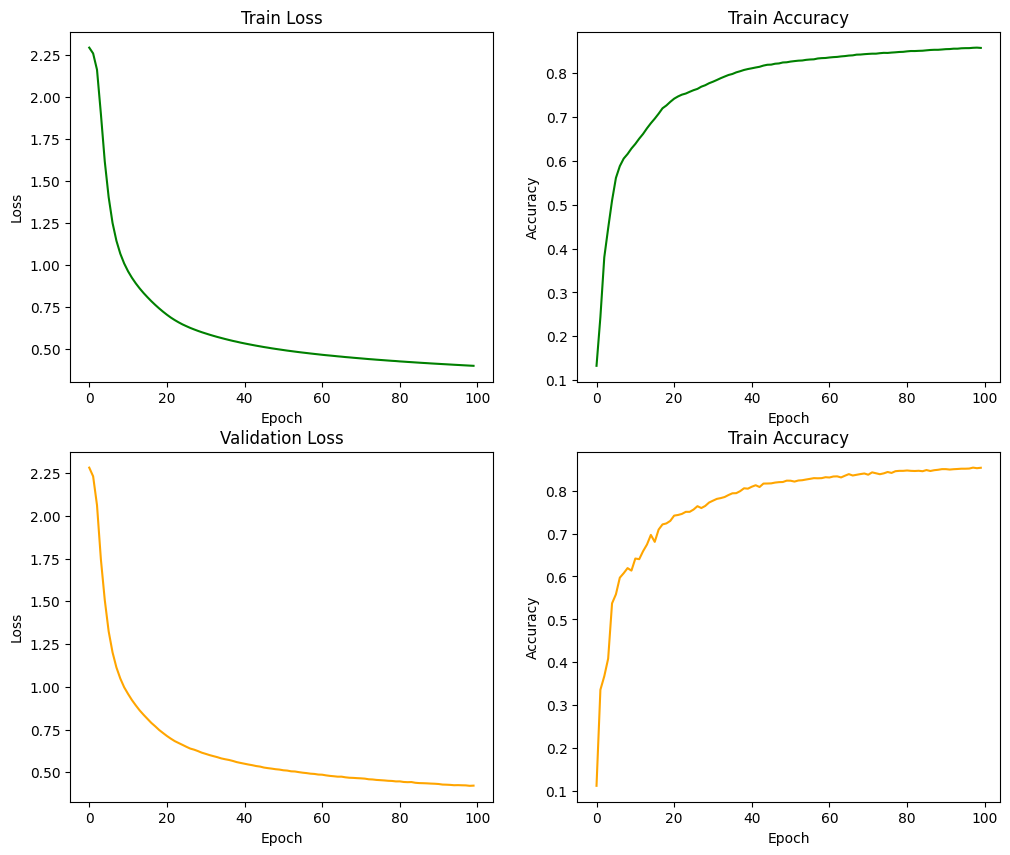

In [54]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **4. Training 2**

In [55]:
# initialize
# first được giữ cố dịnh, không cập nhật trọng số
for param in first.parameters():
  param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [58]:
# Số lượng epochs (chu kỳ huấn luyện) cho quá trình training
# Mỗi epoch, mô hình sẽ được huấn luyện trên toàn bộ tập dữ liệu training một lần
# Với epochs = 100, mô hình sẽ được huấn luyện 100 lần trên tập dữ liệu
epochs = 100
train_loss_lst =[]
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

# Lặp qua số epochs đã định
for epoch in range(epochs):
  # Khởi tạo các biến để tính loss và accuracy cho tập train
  train_loss = 0
  train_acc = 0
  count = 0
  # Chuyển model sang chế độ train
  model.train()
  # Lặp qua từng batch dữ liệu train
  for X_train, y_train in train_loader:
    # Chuyển dữ liệu sang device (GPU/CPU)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    # Xóa gradient tích lũy từ bước trước
    optimizer.zero_grad()
    # Forward pass: tính output của model
    outputs = model(X_train)
    # Tính loss giữa output và ground truth
    loss = criterion(outputs, y_train)
    # Backward pass: tính gradient
    loss.backward()
    # Cập nhật trọng số dựa trên gradient
    optimizer.step()
    # Cộng dồn loss và accuracy
    train_loss += loss.item()
    # Tính số lượng dự đoán đúng trong batch hiện tại:
    # 1. torch.argmax(outputs,1): Lấy chỉ số của giá trị lớn nhất trên mỗi hàng (dim=1) của outputs
    #    -> Đây chính là nhãn được dự đoán bởi mô hình
    # 2. == y_train: So sánh với nhãn thực tế, trả về tensor boolean (True nếu dự đoán đúng)
    # 3. .sum(): Đếm số lượng giá trị True (số lượng dự đoán đúng)
    # 4. .item(): Chuyển đổi tensor thành số Python
    # Cộng dồn số lượng dự đoán đúng vào biến train_acc
    train_acc += (torch.argmax(outputs,1) == y_train).sum().item()
    count += len(y_train)
  # Tính trung bình loss và accuracy trên tập train
  train_loss /= len(train_loader)
  train_loss_lst.append(train_loss)
  train_acc /= count
  train_acc_lst.append(train_acc)

  # Khởi tạo các biến để tính loss và accuracy cho tập validation
  val_loss = 0.0
  val_acc = 0.0
  count = 0
  # Chuyển model sang chế độ evaluation
  model.eval()
  # Tắt tính toán gradient khi validate vì:
  # 1. Không cần cập nhật trọng số trong quá trình validation
  # 2. Giúp tăng tốc độ tính toán và tiết kiệm bộ nhớ
  # 3. Đảm bảo kết quả đánh giá nhất quán vì không có sự thay đổi của trọng số
  with torch.no_grad():
    # Lặp qua từng batch dữ liệu validation
    for X_val, y_val in val_loader:
      # Chuyển dữ liệu sang device
      X_val = X_val.to(device)
      y_val = y_val.to(device)
      # Tính output
      outputs = model(X_val)
      # Tính loss
      loss = criterion(outputs, y_val)
      # Cộng dồn loss và accuracy
      val_loss += loss.item()
      val_acc += (torch.argmax(outputs,1) == y_val).sum().item()
       # Train size có thể khác so với tổng số mẫu thực tế dùng(do loại bỏ mẫu lỗi..?)
      count += len(y_val)
  # Tính trung bình loss và accuracy trên tập validation
  val_loss /= len(val_loader)
  val_loss_lst.append(val_loss)
  val_acc /= count # Chia cho số mẫu thực tế đã sử dụng
  val_acc_lst.append(val_acc)

  # In kết quả sau mỗi epoch
  print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f},Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f} , Val_Acc:{val_acc:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x128 and 784x128)

In [56]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x128 and 784x128)

In [ ]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **5. Training 3**

In [ ]:
# initialize
# huấn luyện lại toàn bộ mạng hiện có mà không cố định thành phần nào
for param in first.parameters():
  param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

In [ ]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **6. Training 4**


In [ ]:
# initialize
for param in first.parameters():
  param.requires_grad = False
for param in second.parameters():
  param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

In [ ]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **7. Training 5**


In [ ]:
for param in first.parameters():
  param.requires_grad = True
for param in second.parameters():
  param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

In [ ]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **8. Training 6**


In [ ]:
for param in first.parameters():
  param.requires_grad = False
for param in second.parameters():
  param.requires_grad = False
for param in third.parameters():
  param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

In [ ]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **8. Training 7**

In [ ]:
for param in first.parameters():
  param.requires_grad = True
for param in second.parameters():
  param.requires_grad = True
for param in third.parameters():
  param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)
print(f"model parameters = {model.parameters()}")

In [ ]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

In [ ]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **10. Evaluation**

In [ ]:
test_label = []
test_predict = []

model.eval()
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test, y_test = X_test.to(device), y_test.to(device)

    output = model(X_test)

    # transfer to CPU, currently it is tensor
    test_label.append(y_test.cpu())
    test_predict.append(output.cpu())

  test_label = torch.cat(test_label, dim=0)
  test_predict = torch.cat(test_predict, dim=0)
  test_acc = (torch.argmax(test_predict, dim=1) == test_label).sum().item()/len(test_label)

print(f"Test accuracy: {test_acc}")

In [ ]:
val_label = []
val_predict = []

model.eval()
with torch.no_grad():
  for X_val, y_val in val_loader:
    X_val, y_val = X_val.to(device), y_val.to(device)

    output = model(X_val)

    # transfer to CP, currently it is tensor
    val_label.append(y_val.cpu())
    val_predict.append(output.cpu())

  val_label = torch.cat(val_label, dim=0)
  val_predict = torch.cat(val_predict, dim=0)
  val_acc = (torch.argmax(val_predict, dim=1) == val_label).sum().item()/len(val_label)

print(f"Validation accuracy: {val_acc:.4f}")